In [1]:
import numpy as np
import random, operator, pandas as pd, matplotlib.pyplot as plt
import time

In [2]:
class City:
    def __init__(self,i, x, y):
        self.i = int(i)
        self.x = float(x)
        self.y = float(y)

    # Calculate the distance between two cities
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance

    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [3]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0.0
        self.fitness = 0.0

    # Calculate the distance for one individual
    def routeDistance(self):
        if self.distance == 0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance

    # Calculate fitness for one individual
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

Fuctions for reading data from files and convert it to suotable form

In [4]:
# Read the data from the file
def read_data(filename):
    with open(filename) as f:
        data = f.readlines()
        return data

# Return all of the cities in the file in a suitable format
def all_Citys(citys):
    all_city = []
    for c in citys:
        city_info = c.rsplit()
        city = City(i=city_info[0], x=city_info[1], y=city_info[2])
        all_city.append(city)
    return all_city

Functions for Creating our First Generations

In [5]:
# Create one individual
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

# Create the first population
def initialPopulation(popSize, cityList):
    population = []
    for i in range(0, popSize):
        population.append(createRoute(cityList))

    return population

specify the ranks of the individuals by theire Fitness property

In [6]:
# Rank individuals
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [7]:
# Create a selection function that will be used to make the list of parent routes
def selection(popRanked, remainingSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index", "Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100 * df.cum_sum / df.Fitness.sum()

    for i in range(0, remainingSize):
        selectionResults.append(popRanked[i][0])

    for i in range(0, len(popRanked) - remainingSize):
        pick = 100 * random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i, 3]:
                selectionResults.append(popRanked[i][0])
                break

    return selectionResults

In [8]:
# Selecting the parents of the next Generation
def matingPool(population, selectionResults):
    matingpool = []
    # while len(matingpool) != len(selectionResults):
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        # if population[index] not in matingpool:
        matingpool.append(population[index])
    return matingpool

In [9]:
# Create a crossover function for two parents to create one child (should be changed)
def crossover(parent1, parent2, crossover_rate):
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    fit_par1 = Fitness(parent1).routeFitness()
    fit_par2 = Fitness(parent2).routeFitness()
    if fit_par1 > fit_par2:
        stronger_parent = parent1
        weaker_parent = parent2
    else:
        stronger_parent = parent2
        weaker_parent = parent1

    x = random.random()
    if x > crossover_rate:
        child = stronger_parent

    else:
        child1 = []

        for i in range(startGene, endGene):
            child1.append(stronger_parent[i])

        child2 = [item for item in weaker_parent if item not in child1]
        child =child1 + child2
    return child

In [10]:
# Create function to run crossover over all of population pair
def crossoverPopulation(matingpool, remainingSize, crossover_rate):
    children = []
    length = len(matingpool) - remainingSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0, remainingSize):
        children.append(matingpool[i])


    while len(children) - remainingSize != length:
        par_index = np.random.randint(0, len(pool),2)
        if pool[par_index[0]] == pool[par_index[1]]:
            continue
        child = crossover(pool[par_index[0]], pool[par_index[1]], crossover_rate)
        if child not in children:
            children.append(child)

    return children

In [11]:
# Create mutation for a single route
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if (random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))

            city1 = individual[swapped]
            city2 = individual[swapWith]

            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [12]:
# Create mutation over all of our population
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    length = len(population)

    while len(mutatedPop) != length:
        ind = np.random.randint(0, length)
        mutatedInd = mutate(population[ind], mutationRate)

        if mutatedInd not in mutatedPop:
            mutatedPop.append(mutatedInd)

    return mutatedPop

In [13]:
# Create the next generation by pulling all steps together
def nextGeneration(currentGen, remainingSize, mutationRate, crossover_rate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, remainingSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = crossoverPopulation(matingpool, remainingSize, crossover_rate)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [14]:
# Final step: create the genetic algorithm
def geneticAlgorithm(population, popSize, remainingSize, mutationRate, crossover_rate, generations, plot= True):
    pop = initialPopulation(popSize, population)
    fit = []
    dis = []
    if plot:
        rank = rankRoutes(pop)[0][1]
        fit.append(rank)
        dis.append(1/rank)

    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))

    for i in range(0, generations):
        pop = nextGeneration(pop, remainingSize, mutationRate, crossover_rate)
        if plot:
            rank = rankRoutes(pop)[0][1]
            fit.append(rank)
            dis.append(1/rank)

    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    if plot:
        plt.plot(fit, color='blue', linestyle='dotted')
        plt.ylabel('Fit')
        plt.xlabel('Generation')
        plt.show()
        plt.plot(dis, color='blue', linestyle='dotted')
        plt.ylabel('Distance')
        plt.xlabel('Generation')
        plt.show()

    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

Initial distance: 82235.88503450878


Final distance: 24331.859337437807


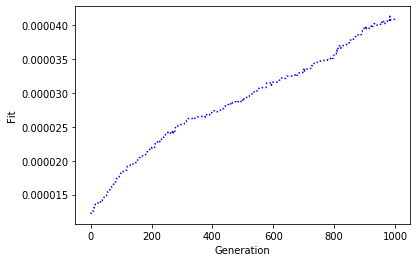

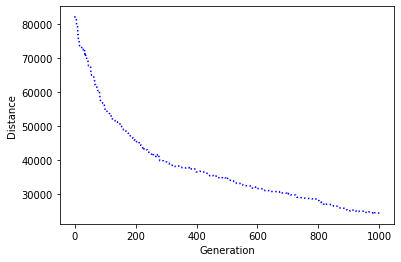

elapsed time is:  11.426928357283275 min


In [15]:
if __name__ == '__main__':

    start = time.time()

    cityList = all_Citys(read_data('tsp_data.txt'))
    bestRoute = geneticAlgorithm(population=cityList, popSize=200,
                                 remainingSize=50, mutationRate=0.0001, crossover_rate=0.8, generations=1000)
    end = time.time()
    
    print('elapsed time is: ', (end-start)/60.0, 'min')